In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import enefit
import holidays
import datetime
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
gas_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
fw_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv')
locations = pd.read_csv('/kaggle/input/county-lon-lats/county_lon_lats.csv')

In [3]:
def TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df):
    '''Train data preprocessing'''
    
    # Drop nan values
    train = train[train['target'].notnull()]
    
    # Converting to datetime & date feature engineering
    train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
    
    train['year'] = train['datetime'].dt.year
    train['quarter'] = train['datetime'].dt.quarter
    train['month'] = train['datetime'].dt.month
    train['week'] = train['datetime'].dt.isocalendar().week
    train['day'] = train['datetime'].dt.day
    train['hour'] = train['datetime'].dt.hour
    train['dayofweek'] = train['datetime'].dt.dayofweek
    train['dayofyear'] = train['datetime'].dt.dayofyear

    train['week'] = train['week'].astype('int32')
    
    train["jan_flag"] = (train["month"] == 1).astype(int)

    # Client data processing
    # Subtracting 2 from data_block_id. Data is two steps ahead
    client_df['data_block_id'] -= 2
    
    # Average installed capacity. (installed_capacity / eic_count)
    client_df['avg_installed_cap'] = client_df['installed_capacity'] / client_df['eic_count']

    
    # Electricity data processing
    # Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity_df = electricity_df.rename(columns= {'forecast_date' : 'datetime'})
    
    # Converting (datetime) column to datetime
    electricity_df['datetime'] = pd.to_datetime(electricity_df['datetime'], utc= True)
    
    electricity_df['hour'] = electricity_df['datetime'].dt.hour
    
    # Locations data processing
    # Drop
    locations = locations.drop('Unnamed: 0', axis= 1) 
        

    # Forecast Weather 
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    
    # 1.
    fw_df[['latitude', 'longitude']] = fw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    fw_df = fw_df.merge(locations, how='left', on=['latitude', 'longitude'])
    
    # 3.
    fw_df.dropna(axis=0, inplace=True)
    
    # 4.
    fw_df['county'] = fw_df['county'].astype('int64')
    
    # 5.
    fw_df.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead',
               'data_block_id'], axis=1, inplace=True)
    
    # 6.
    fw_df.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    fw_df['datetime'] = pd.to_datetime(fw_df['datetime'], utc=True)
    
    # 7.
    fw_df_mean = fw_df.groupby([fw_df['datetime']
                                .dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1)
                                                                           .columns)].mean().reset_index()
    fw_df_mean['datetime'] = pd.to_datetime(fw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    # 8. 
    fw_df_county = fw_df.groupby(['county', fw_df['datetime'].dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    fw_df_county['datetime'] = pd.to_datetime(fw_df_county['datetime'].dt.to_timestamp(), utc=True)

    
    # Historical weather df processing
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    # 9. Merge data_block_id back to new county df
   
    # 1.
    hw_df[['latitude', 'longitude']] = hw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    hw_df = hw_df.merge(locations, how='left', on=['longitude', 'latitude'])
    
    # 3.
    hw_df.dropna(axis=0, inplace=True)
    
    # 4.
    hw_df['county'] = hw_df['county'].astype('int64')
    
    # 5.
    hw_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 6.
    hw_df['datetime'] = pd.to_datetime(hw_df['datetime'], utc=True)
    
    # 7.
    hw_df_mean = hw_df.groupby([hw_df['datetime']
                                .dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1)
                                                                           .columns)].mean().reset_index()
    hw_df_mean['datetime'] = pd.to_datetime(hw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    hw_df_mean = hw_df_mean.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 8. 
    hw_df_county = hw_df.groupby(['county', hw_df['datetime'].dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
    hw_df_county['datetime'] = pd.to_datetime(hw_df_county['datetime'].dt.to_timestamp(), utc=True)
    hw_df_county = hw_df_county.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_county.reset_index()
    
    # Merge the data into train set
    # 1. Merge client 
    # 2. Merge gas
    # 3. Merge electricity
    # 4. Merge forecast weather
    # 5. Merge forecast weather by county
    # 6. Add hour col to hist weather and hist county. Drop dups and datetime col
    # 7. Merge hist weather menas
    # 8. Merge hist weather means by county
    # 9. Fill null values with forward and backward method
    # 10. Drop un-necessary cols...?

    
    # 1
    train = train.merge(client_df.drop(columns = ['date']), how='left', on = ['data_block_id', 'county', 'is_business', 'product_type'])
    
    # 2
    train = train.merge(gas_df[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    # 3
    train = train.merge(electricity_df[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour','data_block_id'])
    
    # 4 
    train = train.merge(fw_df_mean, how='left', on='datetime')
    
    # 5 
    train = train.merge(fw_df_county, how='left', on=['datetime', 'county'], suffixes = ('_fcast_mean', '_fcast_mean_by_county'))
    
    # 6
    hw_df_mean['hour'] = hw_df_mean['datetime'].dt.hour
    hw_df_county['hour'] = hw_df_county['datetime'].dt.hour
    
    hw_df_mean.drop_duplicates(inplace=True)
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_mean.drop('datetime', axis=1, inplace=True)
    hw_df_county.drop('datetime', axis=1, inplace=True)

    # 7
    train = train.merge(hw_df_mean, how='left', on=['data_block_id', 'hour'])
    
    # 8 
    train = train.merge(hw_df_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes= ('_hist_mean', '_hist_mean_by_county'))
    
    # 9
    train = train.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    # 10
    train.drop(['row_id', 'data_block_id'], axis = 1, inplace = True)
    
    # Normalize target by dividing against installed capacity
    train['installed_capacity'] = train['installed_capacity'].fillna(1000)
    train['target'] = train['target'] / train['installed_capacity']

    return train

In [4]:
def is_holiday(dataframe):
    '''Creates is_holiday boolean column for Estonian country wide holidays'''
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2024))
    estonian_holidays = list(estonian_holidays.keys())

    
    dataframe['is_holiday'] = dataframe.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)
    return dataframe

In [5]:
def create_target_lags(train, N_lags):
    '''Lag target variables are a form of feature engineering that gives
    the model context for what the target was N days ago'''
    
    # Store datetime column in a python object
    og_datetime = train['datetime']
    
    # Store important variables to reference with target
    target_and_friends = train[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create lagged targets
    for lag in range(1, N_lags+ 1): # Starts at 2, ends at set day
        target_and_friends['datetime'] = og_datetime + pd.DateOffset(lag) # Shifts dates forward by set amount (lag)
        train = train.merge(target_and_friends, how='left', on=['datetime', 'prediction_unit_id', 'is_consumption'], suffixes = ('', f'_{lag}_days_ago'))
        
    return train

In [6]:
# Train preprocessing
train = TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df)

# Add holidays
train = is_holiday(train)

# Add target lags
N_lags = 2
train = create_target_lags(train, N_lags) #Any number after 2
train.head()

,level_0,level_1,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,year,...,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,is_holiday,target_1_days_ago,target_2_days_ago
0,0,0,0,0,1,0.000748,0,2021-09-01 00:00:00+00:00,0,2021,...,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN
1,0,1,0,0,1,0.101365,1,2021-09-01 00:00:00+00:00,0,2021,...,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN
2,0,2,0,0,2,0.000000,0,2021-09-01 00:00:00+00:00,1,2021,...,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN
3,0,3,0,0,2,0.104050,1,2021-09-01 00:00:00+00:00,1,2021,...,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN
4,0,4,0,0,3,0.000403,0,2021-09-01 00:00:00+00:00,2,2021,...,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN


In [7]:
# Drop year column as its no longer needed
train.drop(['year'], axis=1, inplace=True)

In [8]:
# Further feature engineering

# Convert datetime to integer for date features
train['datetime'] = train['datetime'].astype('int64')

train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(1, N_lags+ 1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(1, N_lags + 1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(1, N_lags+ 1)]].var(1)


In [9]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 85 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   level_0                                                 int64  
 1   level_1                                                 int64  
 2   county                                                  int64  
 3   is_business                                             int64  
 4   product_type                                            int64  
 5   target                                                  float64
 6   is_consumption                                          int64  
 7   datetime                                                int64  
 8   prediction_unit_id                                      int64  
 9   quarter                                                 int32  
 10  month                                                 

In [10]:
# Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_1_days_ago', 'target_2_days_ago', 'target_mean', 'target_std', 'target_var']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0) #Create new col and log the value if not 0
    

In [11]:
train.shape

(2017824, 115)

In [12]:
# Sort by datetime
train.sort_values(['datetime', 'hour'], inplace=True)

In [13]:
# Set the display options to show all rows and columns
pd.set_option('display.max_columns', None)

train.head(900000)

,level_0,level_1,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,quarter,month,week,day,hour,dayofweek,dayofyear,jan_flag,eic_count,installed_capacity,avg_installed_cap,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,is_holiday,target_1_days_ago,target_2_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var,log_installed_capacity,log_euros_per_mwh,log_temperature_fcast_mean,log_dewpoint_fcast_mean,log_cloudcover_high_fcast_mean,log_cloudcover_low_fcast_mean,log_cloudcover_mid_fcast_mean,log_cloudcover_total_fcast_mean,log_10_metre_u_wind_component_fcast_mean,log_direct_solar_radiation_fcast_mean,log_snowfall_fcast_mean,log_total_precipitation_fcast_mean,log_temperature_fcast_mean_by_county,log_dewpoint_fcast_mean_by_county,log_cloudcover_high_fcast_mean_by_county,log_cloudcover_low_fcast_mean_by_county,log_cloudcover_mid_fcast_mean_by_county,log_cloudcover_total_fcast_mean_by_county,log_10_metre_u_wind_component_fcast_mean_by_county,log_surface_solar_radiation_downwards_fcast_mean_by_county,log_snowfall_fcast_mean_by_county,log_total_precipitation_fcast_mean_by_county,log_rain_hist_mean,log_snowfall_hist_mean,log_windspeed_10m_hist_mean_by_county,log_target_1_days_ago,log_target_2_days_ago,log_target_mean,log_target_std,log_target_var
0,0,0,0,0,1,0.000748,0,1630454400000000000,0,3,9,35,1,0,2,244,0,108.0,952.89,8.823056,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.000000,0.00000,0.0,6.877303e-05,9.205896,4.282617,0.132951,0.503769,0.874930,0.965574,-3.168878,4.505805,0.000000,0.000000,0.0,0.000004,8.982667,6.233333,0.0,0.000000,1026.648000,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.600000,8.840000,6.710000,0.0,0.0,1028.510000,93.3,87.6,24.200000,0.0,4.169444,143.0,0.000000,0.000000,0.0,0,NaN,NaN,0.000000,0.261799,-0.014842,0.008628,NaN,NaN,NaN,6.859499,4.267737,2.232450,1.743708,-1.584392,-0.50909,-0.209217,-0.097708,NaN,0.000000,0.0,-9.584699,2.219844,1.454564,-2.017772,-0.685638,-0.133611,-0.035033,NaN,0.000000,0.0,-12.404329,0.0,0.000000,1.427783,NaN,NaN,NaN,NaN,NaN
1,0,1,0,0,1,0.101365,1,1630454400000000000,0,3,9,35,1,0,2,244,0,108.0,952.89,8.823056,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.87714

In [14]:
# drop index column
train.drop(['level_0', 'level_1'], axis=1, inplace=True)

In [15]:
# Drop nan values
train2 = train.dropna(axis=0)
train2.shape

(671822, 113)

In [16]:

train = train2

## Modeling

In [17]:
# Select features and targets for consumption and production

consumption_X = train[train['is_consumption'] == 1].drop(['is_consumption', 'target'], axis=1)
consumption_y = train[train['is_consumption'] == 1]['target']

production_X = train[train['is_consumption'] == 0].drop(['is_consumption', 'target'], axis=1)
production_y = train[train['is_consumption'] == 0]['target']

In [18]:
# Normalize features

scaler = MinMaxScaler()
consumption_X = scaler.fit_transform(consumption_X)
production_X = scaler.fit_transform(production_X)

In [19]:
# Split into train and test sets

consumption_X_train, consumption_X_test, consumption_y_train, consumption_y_test = train_test_split(consumption_X, consumption_y, test_size=0.2, random_state=42)
production_X_train, production_X_test, production_y_train, production_y_test = train_test_split(production_X, production_y, test_size=0.2, random_state=42)


In [20]:
# Reshape features for LSTM
consumption_X_train = consumption_X_train.reshape((consumption_X_train.shape[0], 1, consumption_X_train.shape[1]))
consumption_X_test = consumption_X_test.reshape((consumption_X_test.shape[0], 1, consumption_X_test.shape[1]))

production_X_train = production_X_train.reshape((production_X_train.shape[0], 1, production_X_train.shape[1]))
production_X_test = production_X_test.reshape((production_X_test.shape[0], 1, production_X_test.shape[1]))

In [21]:
# Build LSTM model

# Consumption
consumption_model = Sequential()
consumption_model.add(LSTM(50, activation='relu', input_shape=(consumption_X_train.shape[1], consumption_X_train.shape[2])))
consumption_model.add(Dense(1))
consumption_model.compile(loss='mse', optimizer='adam')

# Production
production_model = Sequential()
production_model.add(LSTM(50, activation='relu', input_shape=(production_X_train.shape[1], production_X_train.shape[2])))
production_model.add(Dense(1))
production_model.compile(loss='mse', optimizer='adam')


In [22]:
# Fit LSTM model
consumption_history = consumption_model.fit(consumption_X_train, consumption_y_train, 
                                            epochs=2, batch_size=72, 
                                            validation_data=(consumption_X_test, consumption_y_test), 
                                            verbose=2, shuffle=False)

production_history = production_model.fit(production_X_train, production_y_train, 
                                          epochs=2, batch_size=72, 
                                          validation_data=(production_X_test, production_y_test), 
                                          verbose=2, shuffle=False)



Epoch 1/2
3733/3733 - 14s - loss: 0.0222 - val_loss: 0.0143 - 14s/epoch - 4ms/step
Epoch 2/2
3733/3733 - 10s - loss: 0.0157 - val_loss: 0.0150 - 10s/epoch - 3ms/step
Epoch 1/2
3733/3733 - 12s - loss: 0.0054 - val_loss: 0.0039 - 12s/epoch - 3ms/step
Epoch 2/2
3733/3733 - 11s - loss: 0.0044 - val_loss: 0.0033 - 11s/epoch - 3ms/step


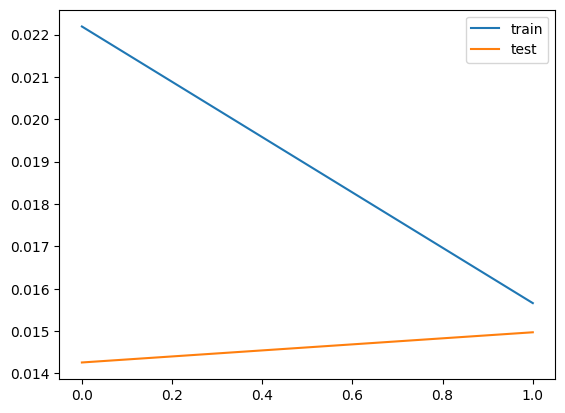

In [23]:
# Plot consumption loss
plt.plot(consumption_history.history['loss'], label='train')
plt.plot(consumption_history.history['val_loss'], label='test')
plt.legend()
plt.show()


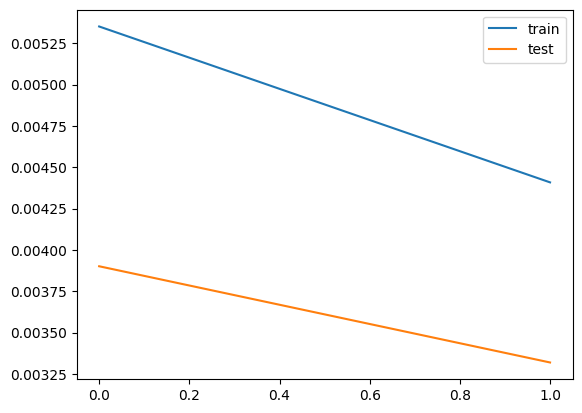

In [24]:
# Plot production loss
plt.plot(production_history.history['loss'], label='train')
plt.plot(production_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
# Make predictions
consumption_yhat = consumption_model.predict(consumption_X_test)

production_yhat = production_model.predict(production_X_test)

2100/2100 [==============================] - 3s 2ms/step


In [26]:
# Evaluate MAE
from sklearn.metrics import mean_absolute_error

consumption_mae = mean_absolute_error(consumption_y_test, consumption_yhat)
print('Consumption MAE: %.3f' % consumption_mae)

production_mae = mean_absolute_error(production_y_test, production_yhat)
print('Production MAE: %.3f' % production_mae)

Consumption MAE: 0.067
Production MAE: 0.027


## Submission

In [27]:
def TestPreprocessing(test, client_df, fw_df, electricity_df, gas_df, locations, hw_df):
    '''Test data preprocessing'''

    # Converting to datetime & date feature engineering
    test = test.rename(columns={'prediction_datetime' : 'datetime'})

    test['datetime'] = pd.to_datetime(test['datetime'], utc=True)

    test['year'] = test['datetime'].dt.year
    test['quarter'] = test['datetime'].dt.quarter
    test['month'] = test['datetime'].dt.month
    test['week'] = test['datetime'].dt.isocalendar().week
    test['day'] = test['datetime'].dt.day
    test['hour'] = test['datetime'].dt.hour
    test['dayofweek'] = test['datetime'].dt.dayofweek
    test['dayofyear'] = test['datetime'].dt.dayofyear

    test['week'] = test['week'].astype('int64')

    test["jan_flag"] = (test["month"] == 1).astype(int)

    # Client data processing
    # Subtracting 2 from data_block_id. Data is two steps ahead
    client_df['data_block_id'] -= 2
    
    # Average installed capacity. (installed_capacity / eic_count)
    client_df['avg_installed_cap'] = client_df['installed_capacity'] / client_df['eic_count']

    
    # Electricity data processing
    # Renaming (forecast_date) to (datetime) for merging with the test data later
    electricity_df = electricity_df.rename(columns= {'forecast_date' : 'datetime'})
    
    # Converting (datetime) column to datetime
    electricity_df['datetime'] = pd.to_datetime(electricity_df['datetime'], utc= True)
    
    electricity_df['hour'] = electricity_df['datetime'].dt.hour
    
    # Locations data processing
    # Drop
    locations = locations.drop('Unnamed: 0', axis= 1) 
        

    # Forecast Weather 
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    
    # 1.
    fw_df[['latitude', 'longitude']] = fw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    fw_df = fw_df.merge(locations, how='left', on=['latitude', 'longitude'])
    
    # 3.
    fw_df.dropna(axis=0, inplace=True)
    
    # 4.
    fw_df['county'] = fw_df['county'].astype('int64')
    
    # 5.
    fw_df.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead',
               'data_block_id'], axis=1, inplace=True)
    
    # 6.
    fw_df.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    fw_df['datetime'] = pd.to_datetime(fw_df['datetime'], utc=True)
    
    # 7.
    fw_df_mean = fw_df.groupby([fw_df['datetime']
                                .dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1)
                                                                           .columns)].mean().reset_index()
    fw_df_mean['datetime'] = pd.to_datetime(fw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    # 8. 
    fw_df_county = fw_df.groupby(['county', fw_df['datetime'].dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    fw_df_county['datetime'] = pd.to_datetime(fw_df_county['datetime'].dt.to_timestamp(), utc=True)

    
    # Historical weather df processing
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    # 9. Merge data_block_id back to new county df
   
    # 1.
    hw_df[['latitude', 'longitude']] = hw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    hw_df = hw_df.merge(locations, how='left', on=['longitude', 'latitude'])
    
    # 3.
    hw_df.dropna(axis=0, inplace=True)
    
    # 4.
    hw_df['county'] = hw_df['county'].astype('int64')
    
    # 5.
    hw_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 6.
    hw_df['datetime'] = pd.to_datetime(hw_df['datetime'], utc=True)
    
    # 7.
    hw_df_mean = hw_df.groupby([hw_df['datetime']
                                .dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1)
                                                                           .columns)].mean().reset_index()
    hw_df_mean['datetime'] = pd.to_datetime(hw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    hw_df_mean = hw_df_mean.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 8. 
    hw_df_county = hw_df.groupby(['county', hw_df['datetime'].dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
    hw_df_county['datetime'] = pd.to_datetime(hw_df_county['datetime'].dt.to_timestamp(), utc=True)
    hw_df_county = hw_df_county.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_county.reset_index()
    
    # Merge the data into test set
    # 1. Merge client 
    # 2. Merge gas
    # 3. Merge electricity
    # 4. Merge forecast weather
    # 5. Merge forecast weather by county
    # 6. Add hour col to hist weather and hist county. Drop dups and datetime col
    # 7. Merge hist weather menas
    # 8. Merge hist weather means by county
    # 9. Fill null values with forward and backward method
    # 10. Drop un-necessary cols...?

    
    # 1
    test = test.merge(client_df.drop(columns = ['date']), how='left', on = ['data_block_id', 'county', 'is_business', 'product_type'])
    
    # 2
    test = test.merge(gas_df[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    # 3
    test = test.merge(electricity_df[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour','data_block_id'])
    
    # 4 
    test = test.merge(fw_df_mean, how='left', on='datetime')
    
    # 5 
    test = test.merge(fw_df_county, how='left', on=['datetime', 'county'], suffixes = ('_fcast_mean', '_fcast_mean_by_county'))
    
    # 6
    hw_df_mean['hour'] = hw_df_mean['datetime'].dt.hour
    hw_df_county['hour'] = hw_df_county['datetime'].dt.hour
    
    hw_df_mean.drop_duplicates(inplace=True)
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_mean.drop('datetime', axis=1, inplace=True)
    hw_df_county.drop('datetime', axis=1, inplace=True)

    # 7
    test = test.merge(hw_df_mean, how='left', on=['data_block_id', 'hour'])
    
    # 8 
    test = test.merge(hw_df_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes= ('_hist_mean', '_hist_mean_by_county'))
    
    # 9
    test = test.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    # 9.5
    installed_capacity = test[['row_id', 'installed_capacity']]
    
    # 10
    test.drop(['row_id', 'data_block_id', 'level_0', 'level_1'], axis = 1, inplace = True)

    # Fill in missing values
    test['installed_capacity'] = test['installed_capacity'].fillna(1000)
    
    return test, installed_capacity

In [28]:
def create_revealed_targets_test(data, previous_revealed_targets, N_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 1
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(1, N_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

In [29]:
env = enefit.make_env()
iter_test = env.iter_test()
previous_revealed_targets = []
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0

    data_test, installed_capacity = TestPreprocessing(test, client_test, forecast_weather_test, electricity_test, gas_test, locations, historical_weather_test)
    data_test = is_holiday(data_test)
    
    # Drop year column as its no longer needed
    data_test.drop(['year'], axis=1, inplace=True)
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_lags = N_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(1, N_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(1, N_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(1, N_lags+1)]].var(1)
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    
    # Split into consumption and production
    consumption_test = df_test[df_test['is_consumption'] == 1].drop(['is_consumption', 'currently_scored'], axis=1)
    production_test = df_test[df_test['is_consumption'] == 0].drop(['is_consumption', 'currently_scored'], axis=1)

    test_con = test[test['is_consumption'] == 1]
    test_prod = test[test['is_consumption'] == 0]

    # Normalize features
    consumption_test = scaler.fit_transform(consumption_test)
    production_test = scaler.fit_transform(production_test)

    # Reshape features for LSTM
    consumption_test = consumption_test.reshape((consumption_test.shape[0], 1, consumption_test.shape[1]))

    production_test = production_test.reshape((production_test.shape[0], 1, production_test.shape[1]))
    
    #Predictions
    test_con['target'] = consumption_model.predict(consumption_test).clip(0)
    test_prod['target'] = production_model.predict(production_test).clip(0)

    # Merge predictions back to original df
#    df_test = df_test.merge(target, how='left', on='datetime')
 #   df_test = df_test.merge(target_solar, how='left', on='datetime')

    test = pd.concat([test_con, test_prod], ignore_index=True)
    test.sort_values(by=['row_id'], inplace=True)

    # Add installed capacity
    test = pd.merge(test, installed_capacity, on='row_id')
    test.drop_duplicates(subset='row_id', keep='first', inplace=True)

    test['target'] = test['target'] * test['installed_capacity']
    
    test.drop('installed_capacity', axis=1, inplace=True)
    
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
49/49 [==============================] - 0s 2ms/step
